# Examples: point clouds

In [1]:
import importlib
from pprint import pprint
import sys

from ipywidgets import interact
from ipywidgets import widgets
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
from scipy import interpolate

sys.path.append("..")
import psdist as ps
import psdist.visualization as psv

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["colorbar.width"] = "1.2em"
pplt.rc["cycle"] = "538"
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

Make a six-dimensional distribution.

In [3]:
d = 6
n = int(1e6)
dims = ["x", "px", "y", "py", "z", "pz"]

state = np.random.RandomState(1241)
_Sigma = np.identity(d)
for i in range(d):
    for j in range(i):
        _Sigma[i, j] = _Sigma[j, i] = state.uniform(-0.2, 0.2)
X = state.multivariate_normal(np.zeros(d), _Sigma, size=n)
for _ in range(4):
    scale = state.uniform(0.5, 1.5, size=d)
    loc = state.uniform(-3.0, 3.0, size=d)
    X = np.vstack([X, state.normal(loc=loc, scale=scale, size=(n, d))])
X = X - np.mean(X, axis=0)

## 2D plotting

In [4]:
axis = (0, 1)
_X = ps.cloud.downsample(X[:, axis], 1000)
_dims = [dims[k] for k in axis]

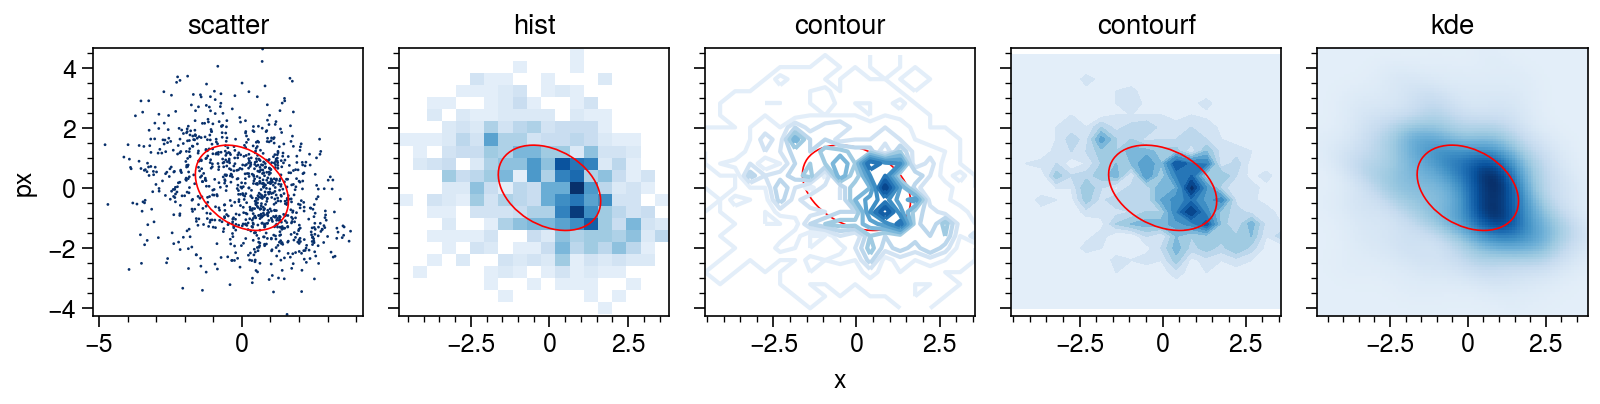

In [5]:
cmap = pplt.Colormap("blues", left=0.1)
kinds = ["scatter", "hist", "contour", "contourf", "kde"]

fig, axs = pplt.subplots(ncols=len(kinds), figwidth=8.0)
for ax, kind in zip(axs, kinds):
    kws = dict()
    if kind == "scatter":
        kws["c"] = cmap(1.0)
        kws["s"] = 1.0
    else:
        kws["cmap"] = cmap
    psv.cloud.plot2d(
        _X, ax=ax, kind=kind, rms_ellipse=True, rms_ellipse_kws=dict(color="red"), **kws
    )
    ax.format(title=kind)
axs.format(xlabel=_dims[0], ylabel=_dims[1])

### Enclosing sphere/ellipsoid 

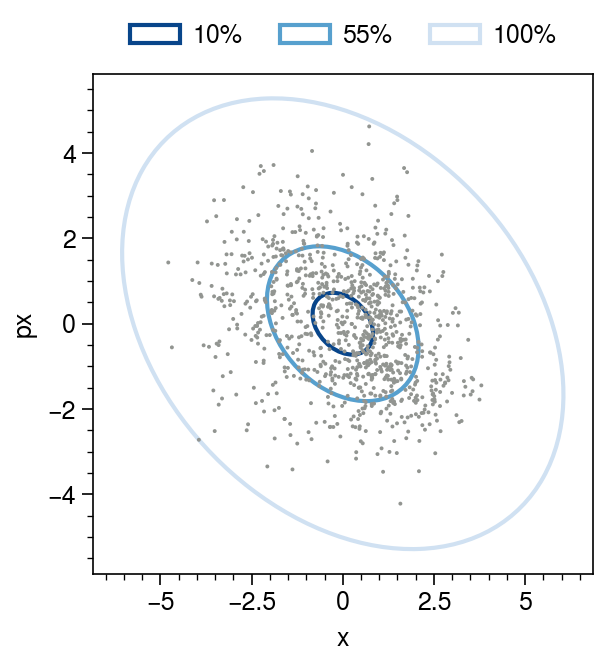

In [6]:
fig, ax = pplt.subplots()
psv.cloud.plot2d(_X, ax=ax, kind="scatter", c="grey")

fractions = np.linspace(0.10, 1.0, 3)
cmap = pplt.Colormap("blues", left=0.2, reverse=True)
for fraction in fractions:
    level = ps.cloud.enclosing_ellipsoid(_X, fraction=fraction)
    psv.cloud.plot_rms_ellipse(
        _X,
        ax=ax,
        level=level,
        color=cmap(fraction),
        lw=1.5,
        label=f"{(100.0 * fraction):.0f}%",
        zorder=0,
    )
ax.legend(loc="t", ncols=3, framealpha=0)
ax.format(xlabel=_dims[0], ylabel=_dims[1]);

### Spherical and ellipsoidal shell slices 

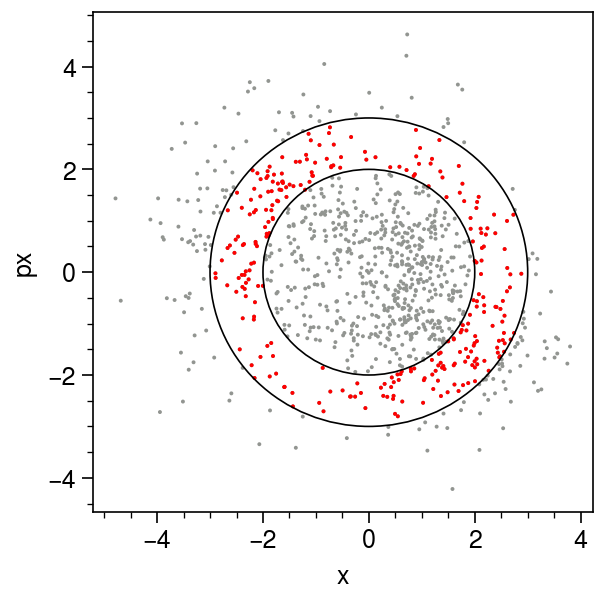

In [7]:
rmin = 2.0
rmax = 3.0
_X1 = ps.cloud.slice_sphere(_X, axis=(0, 1), rmin=rmin, rmax=rmax)

fig, ax = pplt.subplots()
psv.cloud.plot2d(_X, ax=ax, kind="scatter", c="grey")
psv.cloud.plot2d(_X1, ax=ax, kind="scatter", c="red")
for r in [rmin, rmax]:
    psv.circle(r, ax=ax)
ax.format(xlabel=_dims[0], ylabel=_dims[1])

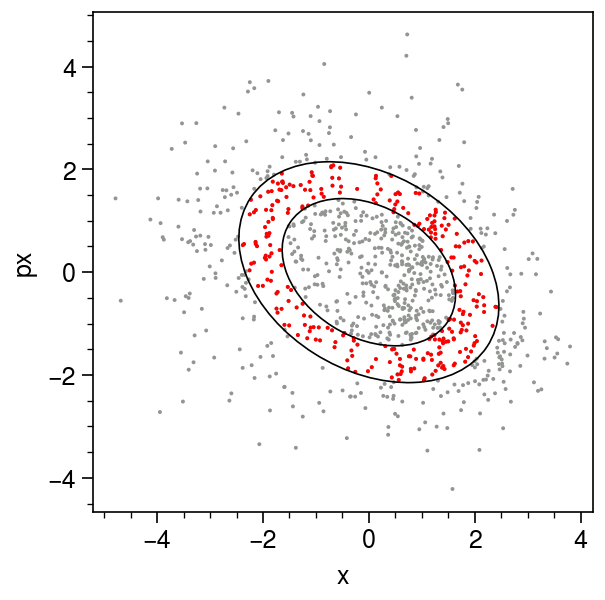

In [8]:
rmin = 1.0
rmax = 1.5
_X1 = ps.cloud.slice_ellipsoid(_X, rmin=rmin, rmax=rmax)

fig, ax = pplt.subplots()
psv.cloud.plot2d(_X, ax=ax, kind="scatter", c="grey")
psv.cloud.plot2d(_X1, ax=ax, kind="scatter", c="red")
for r in [rmin, rmax]:
    psv.cloud.plot_rms_ellipse(X, level=r, ax=ax)
ax.format(xlabel=_dims[0], ylabel=_dims[1])

In [9]:
@interact(radius=widgets.FloatRangeSlider(min=0.0, max=5.0))
def update(radius):
    rmin, rmax = radius
    _Y = ps.cloud.slice_ellipsoid(_X, axis=(0, 1), rmin=rmin, rmax=rmax)

    fig, ax = pplt.subplots()
    ax.format(xlim=(-5.0, 5.0), ylim=(-5.0, 5.0))
    psv.cloud.plot2d(_X, ax=ax, kind="scatter", c="grey")
    psv.cloud.plot2d(_Y, ax=ax, kind="scatter", c="red")
    for r in [rmin, rmax]:
        psv.cloud.plot_rms_ellipse(X, level=r, ax=ax)
    ax.format(xlabel=_dims[0], ylabel=_dims[1]);

interactive(children=(FloatRangeSlider(value=(1.25, 3.75), description='radius', max=5.0), Output()), _dom_cla…

### Contour shell slice

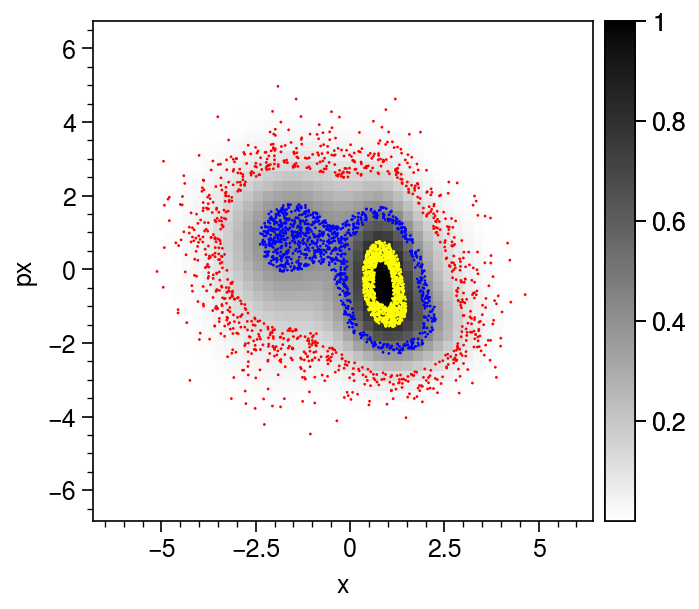

In [10]:
bins = 50

fig, ax = pplt.subplots()
psv.cloud.plot2d(
    X[:, axis],
    ax=ax,
    kind="hist",
    cmap=pplt.Colormap("mono", left=0.0, right=1.0),
    process_kws=dict(norm="max"),
    colorbar=True,
    bins=bins,
    discrete=False,
)
for lmin, c in zip([0.0, 0.4, 0.8], ["red", "blue", "yellow"]):
    lmax = lmin + 0.15
    psv.cloud.plot2d(
        ps.cloud.downsample(
            ps.cloud.slice_contour(X[:, axis], lmin=lmin, lmax=lmax, bins=bins),
            samples=1000,
        ),
        ax=ax,
        kind="scatter",
        c=c,
        s=1.0,
    )
ax.format(xlabel=_dims[0], ylabel=_dims[1]);

### Joint plot 

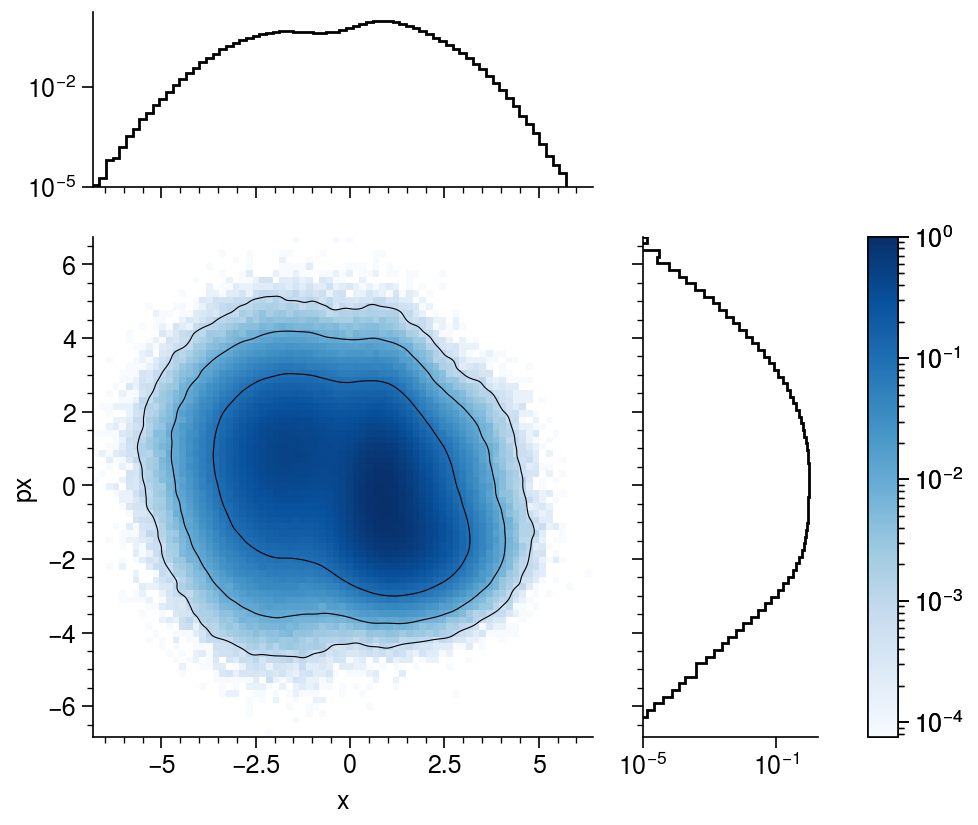

In [11]:
grid = psv.JointGrid(
    marg_kws=dict(space="2.0em", width="7.0em"),
    marg_fmt_kws_x=dict(yspineloc="left", xspineloc="bottom"),
    marg_fmt_kws_y=dict(yspineloc="left", xspineloc="bottom"),
    xspineloc="bottom",
    yspineloc="left",
)
grid.plot_cloud(
    X[:, axis],
    marg_kws=dict(kind="step", color="black", scale="max"),
    marg_hist_kws=dict(bins=75),
    kind="hist",
    process_kws=dict(norm="max"),
    cmap=pplt.Colormap("blues", left=0.0),
    discrete=False,
    norm="log",
    colorbar=True,
    colorbar_kw=dict(width="1.2em", tickminor=True),
)
psv.cloud.plot2d(
    X[:, axis], ax=grid.ax, 
    process_kws=dict(norm="max", blur_sigma=5.0),
    kind="contour", 
    levels=[0.001, 0.01, 0.1, 1.0], 
    colors="black",
    lw=0.4,
)
ymin = 10.0 ** -5.0
ymax = None
grid.ax_marg_x.format(yformatter="log", yscale="log", ymin=ymin, ymax=ymax)
grid.ax_marg_y.format(xformatter="log", xscale="log", xmin=ymin, xmax=ymax)
grid.ax.format(xlabel=_dims[0], ylabel=_dims[1]);

## Corner plot 

In [12]:
alpha = 0.5
cmaps = [pplt.Colormap(name, left=0.2) for name in ["blues", "reds", "greens"]]
colors = [cmap(0.75) for cmap in cmaps]
plot_kws = dict(
    mask=True,
    alpha=alpha,
    rms_ellipse=False,
)
autolim_kws = dict(pad=0.1, zero_center=True)

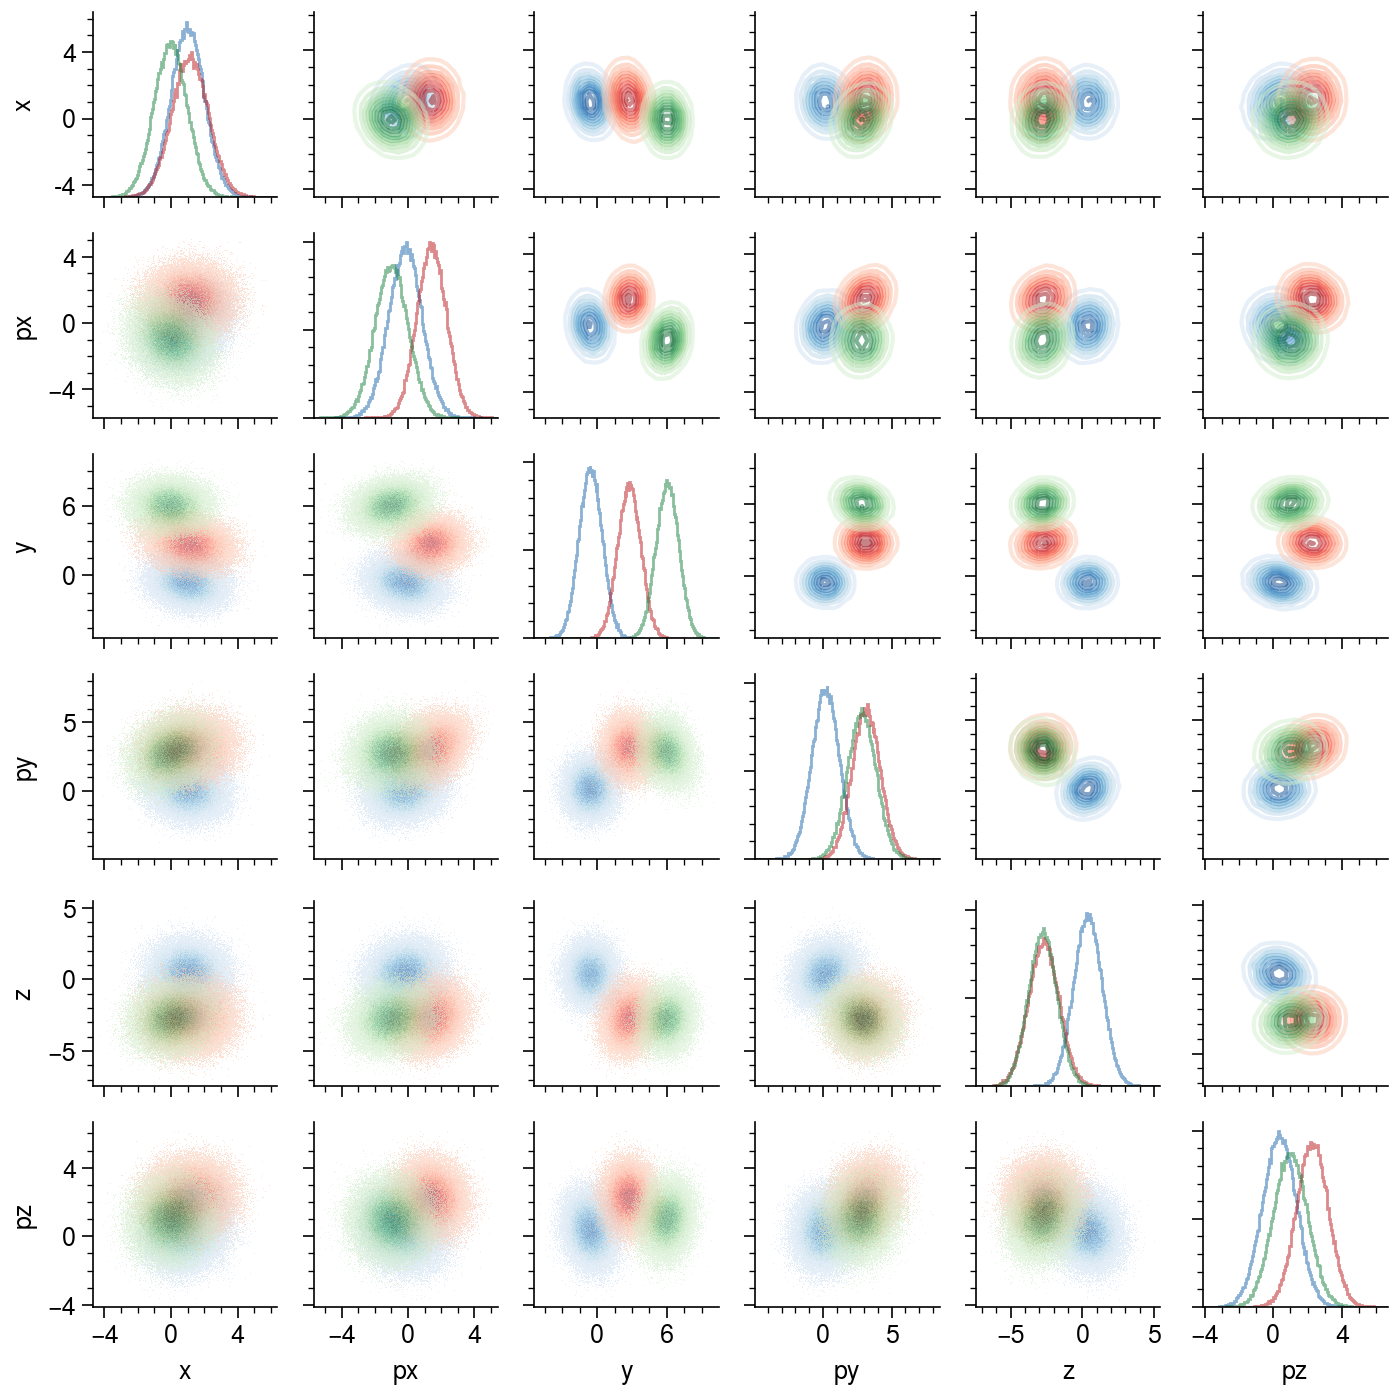

In [13]:
grid = psv.CornerGrid(d=X.shape[1], diag=True, corner=False, figwidth=7.0)
grid.set_labels(dims)
Y = np.copy(X[:int(1e5)])
R = ps.ap.phase_adv_matrix(np.radians(45.0), np.radians(20.0), np.radians(-45.0))
for i in range(3):
    if i > 0:
        Y = ps.cloud.transform_linear(Y, R)
        Y = Y + state.uniform(-3.5, 3.5, size=(1, Y.shape[1]))
        Y[:, 3] += 0.01 * Y[:, 1]**3 - 0.0002 * Y[:, 2]**4 
    grid.plot_cloud(
        Y,
        kind="hist",
        bins="auto",
        lower=True, upper=False,
        diag_kws=dict(color=colors[i], alpha=alpha),
        cmap=cmaps[i],
        **plot_kws,
    )
    grid.plot_cloud(
        Y,
        kind="contour",
        bins=25,
        lower=False, upper=True,
        diag_kws=dict(alpha=0.0),
        cmap=cmaps[i],
        **plot_kws,
    )

### Normalized radial histogram

Normalize by the volume of each spherical shell.

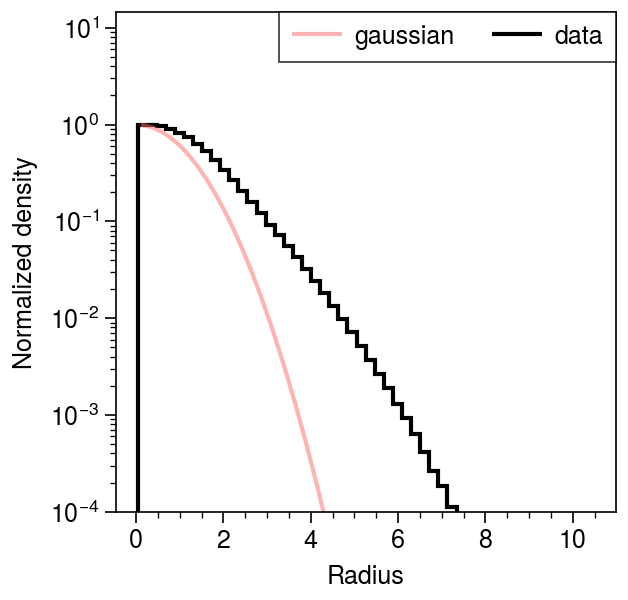

In [14]:
profile, edges = ps.cloud.radial_histogram(X[:, :4], bins=50)
profile = psv.scale_profile(profile, scale="max")
coords = ps.utils.centers_from_edges(edges)

fig, ax = pplt.subplots()
psv.plot_profile(profile, edges=edges, ax=ax, kind="step", color="black", label="data")
ax.plot(coords, np.exp(-0.5 * coords**2), color="red5", alpha=0.5, label="gaussian")
ax.legend()
ax.format(
    yscale="log", yformatter="log", ymin=0.0001, xlabel="Radius", ylabel="Normalized density",
)

Define $\mathbf{r} = [x, y, z]^T$, $\mathbf{r}' = [p_x, p_y, p_z]^T$.

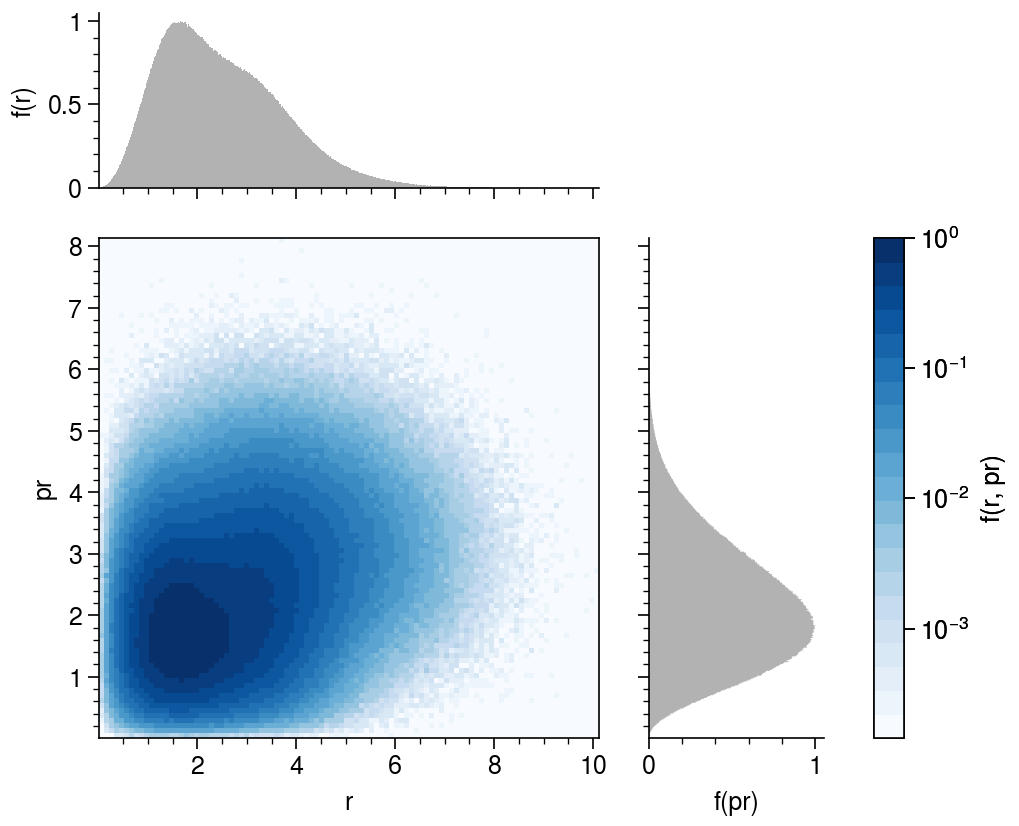

In [15]:
r = ps.cloud.get_radii(X[:, (0, 2, 4)])
pr = ps.cloud.get_radii(X[:, (1, 3, 5)])
R = np.vstack([r, pr]).T

grid = psv.JointGrid(
    marg_kws=dict(space="2.0em", width="7.0em"),
    marg_fmt_kws_x=dict(yspineloc="left", xspineloc="bottom", ylabel="f(r)"),
    marg_fmt_kws_y=dict(yspineloc="left", xspineloc="bottom", xlabel="f(pr)"),
)
grid.plot_cloud(
    R,
    marg_kws=dict(scale="max", fill=True, color="black", alpha=0.3),
    bins=100,
    process_kws=dict(norm="max"),
    offset=1.0,
    N=21,
    norm="log",
    vmax=1.0,
    cmap="blues",
    colorbar=True,
    colorbar_kw=dict(label="f(r, pr)"),
)
ymin = 10.0 ** -6.0
ymax = 5.0
grid.ax.format(xlabel="r", ylabel="pr")

### Sparse histogram

In [16]:
edges = ps.cloud.histogram_bin_edges(X, bins=6)
nonzero_indices, nonzero_counts, nonzero_edges = ps.cloud.sparse_histogram(X, bins=edges)
print(f"Nonzero bins from sparse hist: {len(nonzero_counts)}")

Nonzero bins from sparse hist: 4740


In [17]:
hist, _ = ps.cloud.histogram(X, bins=edges)
print(f"Nonzero bins from hist: {hist[hist > 0].size}")

Nonzero bins from hist: 4740


## Slice matrix plot 

[To do...]

## Interactive slicing

## 1D 

In [18]:
X = X - np.mean(X, axis=0)
Y = Y - np.mean(Y, axis=0)
data = [
    [Y, X, 2.0 * X],
    [X, -Y, -2.0 * Y],
]

In [19]:
psv.cloud.proj1d_interactive_slice(
    data=data,
    dims=dims,
    slice_type="int",
    options=dict(
        alpha=True,
        auto_plot_res=False,
        kind=True,
        log=True,
        normalize=False,
        scale=False,
    ),
    share_limits=False,
    legend=True,
    labels=None,
    cycle="538",
)

interactive(children=(BoundedIntText(value=0, description='frame', max=2), Dropdown(description='dim', options…

### 2D 

In [20]:
plot_kws = dict(
    profx=True,
    profy=True,
    prof_kws=dict(color="white"),
    process_kws=dict(norm="max"),
    autolim_kws=dict(pad=0.1),
    offset=1.0,
    colorbar=True, 
    colorbar_kw=dict(tickminor=True, width="1.2em"),
)

In [21]:
psv.cloud.proj2d_interactive_slice(
    data=data,
    limits=None, 
    share_limits=1, 
    default_axis=(0, 1), 
    slice_type="int", 
    plot_res=64, 
    slice_res=16, 
    dims=dims, 
    units=None, 
    options=dict(
        auto_plot_res=False,
        discrete=True,
        ellipse=True,
        log=True,
        mask=False,
        normalize=True,
        profiles=True,
    ),
    fig_kws=dict(toplabels=["left", "right"], space=6.0),
    **plot_kws
)

interactive(children=(BoundedIntText(value=0, description='frame', max=2), Dropdown(description='dim 1', optio…